# Overview

This notebook in intended as a generic notebook to be used with the papermill python library to allow automated generation of analyses and reports for classifiers on microbiome data generated by kraken2 pipeline. Here we do differential expression and PCA on the full dataset.

In [1]:
cd /project/src

/project/src


In [2]:
from sklearn import model_selection
from sklearn import metrics
import os
import re
import copy
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester, list_transformer, DiffExpTransform
from ScoreFunctions import *
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model as LM
import seaborn as sns
import pickle as pk
from matplotlib import pyplot as plt
# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Basic Data Loading

In [3]:
input_dir = '/project/data/preprocessed/PE_50K_sex_complete'
retrain = True
fdr_DE = 0.05

In [4]:
os.listdir(input_dir)

['meta_data_mat.pk',
 'metadata_samples_keep.csv',
 'y.pk',
 'X.pk',
 'feat_meta.csv']

In [5]:
infile_X = open(os.path.join(input_dir, 'X.pk'),'rb')
X = pk.load(infile_X)
infile_X.close()
infile_y = open(os.path.join(input_dir, 'y.pk'),'rb')
y = pk.load(infile_y)
infile_y.close()
# infile_meta_data_mat = open(os.path.join(input_dir, 'meta_data_mat.pk'), 'rb')
# meta_data_mat = pk.load(infile_meta_data_mat)
# infile_meta_data_mat.close()
# model input
# X_inp = np.concatenate([X, meta_data_mat], axis=1)
sample_meta = pd.read_csv(os.path.join(input_dir, 'metadata_samples_keep.csv'))
feat_meta = pd.read_csv(os.path.join(input_dir, 'feat_meta.csv'))
X_inp = X

# Run Differential Expression (Abundance)

Note that tests performed are 1 sided t-tests for each class. If we really want we can do FDR correction based off of union of hypotheses tested for each class, but for now, implementation is FDR correction only for 1 set of class hypotheses at a time (i.e. separately apply FDR correction for each class)

In [6]:
DE = DiffExpTransform()
DE.fit(X, y)


In [31]:
DE.results['0']['neg_log10_p']

0       0.001483
1       0.874618
2       0.874619
3       0.874618
4       0.954449
          ...   
1937    0.874619
1938    0.874619
1939    0.874619
1940    0.046491
1941    0.088564
Name: neg_log10_p, Length: 1942, dtype: float64

<AxesSubplot:xlabel='tstat', ylabel='neg_log10_p'>

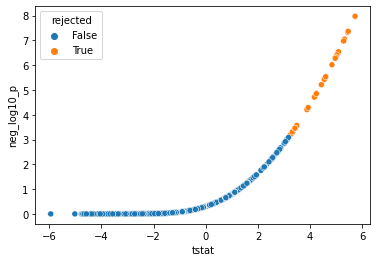

In [41]:
# ACVD Negative Associated Features
DE.results['0']['neg_log10_p'] = -(np.log10(DE.results['0']['pval'].to_numpy()))
sns.scatterplot(data=DE.results['0'], x='tstat', y='neg_log10_p', hue='rejected')

In [8]:
DE.results['0'][DE.results['0']['rejected'] == True].shape[0]

27

In [21]:
feat_meta.iloc[np.argwhere((DE.results['0']['rejected'] == True).to_numpy()).flatten(), :]

,Unnamed: 0,feature
16,36,Alloprevotella sp. E39
30,62,Bacteroides sp. A1C1
31,63,Bacteroides sp. CACC 737
33,65,Bacteroides sp. HF-162
99,223,Muribaculum sp. TLL-A4
123,264,Prevotella sp. oral taxon 299
141,303,Tannerella sp. oral taxon HOT-286
168,366,Alistipes megaguti
230,517,Bacteroides uniformis
233,521,Barnesiella viscericola


<AxesSubplot:xlabel='tstat', ylabel='neg_log10_p'>

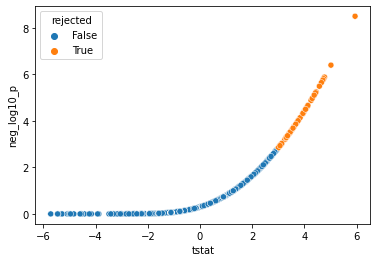

In [42]:
# ACVD Negative Associated Features
DE.results['1']['neg_log10_p'] = -(np.log10(DE.results['1']['pval'].to_numpy()))
sns.scatterplot(data=DE.results['1'], x='tstat', y='neg_log10_p', hue='rejected')

In [22]:
DE.results['1'][DE.results['1']['rejected'] == True].shape[0]

58

In [25]:
feat_meta.iloc[np.argwhere((DE.results['1']['rejected'] == True).to_numpy()).flatten(), :].sort_values('feature')

,Unnamed: 0,feature
683,1915,Actinomyces pacaensis
711,2011,Anaerostipes rhamnosivorans
760,2124,Blautia argi
237,530,Blautia sp. SC05B48
247,574,Candidatus Nanosynbacter lyticus
1647,5233,Clostridiales bacterium Choco116
834,2413,Clostridioides difficile
871,2456,Collinsella aerofaciens
964,2728,Enterocloster bolteae
971,2735,Enterococcus faecium


# Run PCA on Differentially Abundant Features

In [43]:
std_scaler_full = StandardScaler()
X_scaled_full = std_scaler_full.fit_transform(DE.transform(X))
PCA_full = PCA()
X_PCA_full = PCA_full.fit_transform(X_scaled_full)

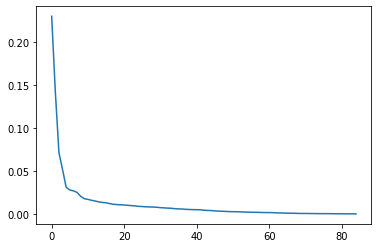

In [44]:
plt.plot(PCA_full.explained_variance_ratio_[0:100])

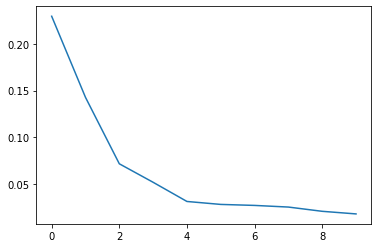

In [45]:
plt.plot(PCA_full.explained_variance_ratio_[0:10])

In [46]:
PCA_full.explained_variance_ratio_[0:10]

array([0.22971365, 0.14271285, 0.07145632, 0.0516075 , 0.03103832,
       0.02786972, 0.02680342, 0.02503638, 0.02048035, 0.0176843 ],
      dtype=float32)

In [47]:
PCA_plot_df = pd.DataFrame(X_PCA_full, columns = np.array(['PC{}'.format(i) for i in range(1, X_PCA_full.shape[1] + 1)]))
PCA_plot_df['ACVD status'] = y

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

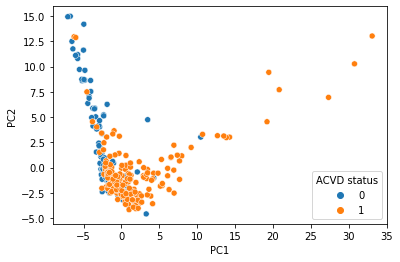

In [48]:
sns.scatterplot(data=PCA_plot_df, x='PC1', y='PC2', hue='ACVD status')

<AxesSubplot:xlabel='PC2', ylabel='PC3'>

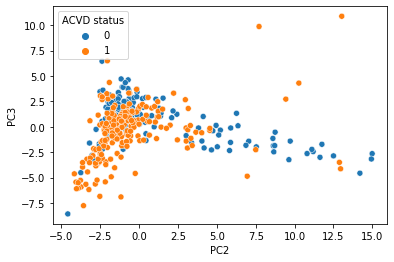

In [49]:
sns.scatterplot(data=PCA_plot_df, x='PC2', y='PC3', hue='ACVD status')

<AxesSubplot:xlabel='PC3', ylabel='PC4'>

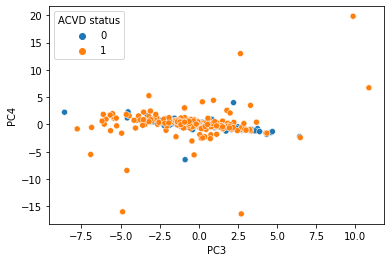

In [50]:
sns.scatterplot(data=PCA_plot_df, x='PC3', y='PC4', hue='ACVD status')